# Projects in AI and ML HW2

In [14]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import confusion_matrix
from scipy.stats import ttest_rel
!pip install scikit-learn==1.1.3
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import warnings
#warnings.filterwarnings("ignore")


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Read data
data_path = "/content/drive/My Drive/Projects in AI and ML/heart.csv"
df = pd.read_csv(data_path)

In [17]:
# Encode non-numeric values to be usable
label_encoder = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])
#df.head()

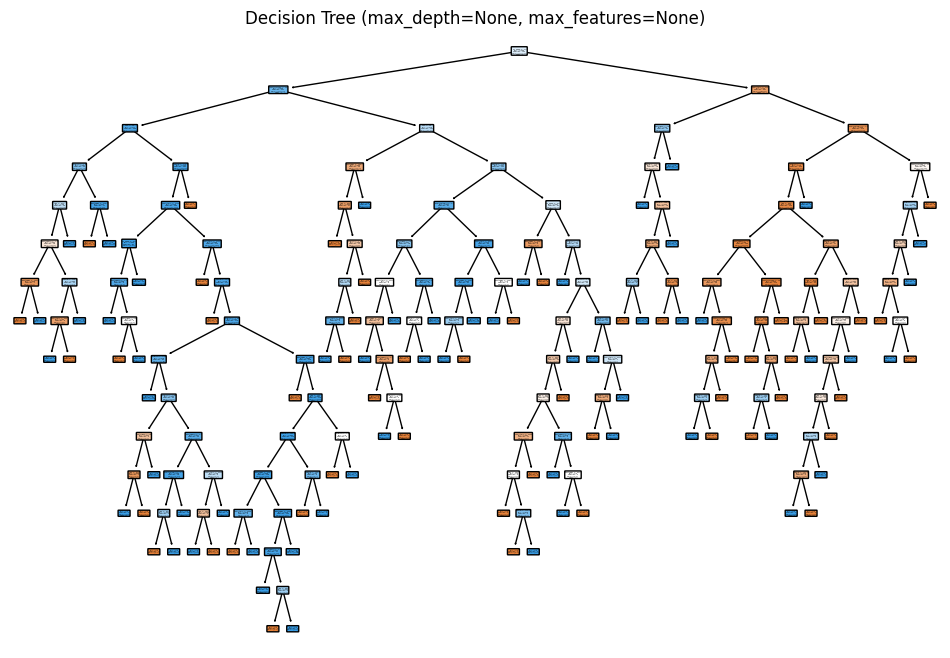

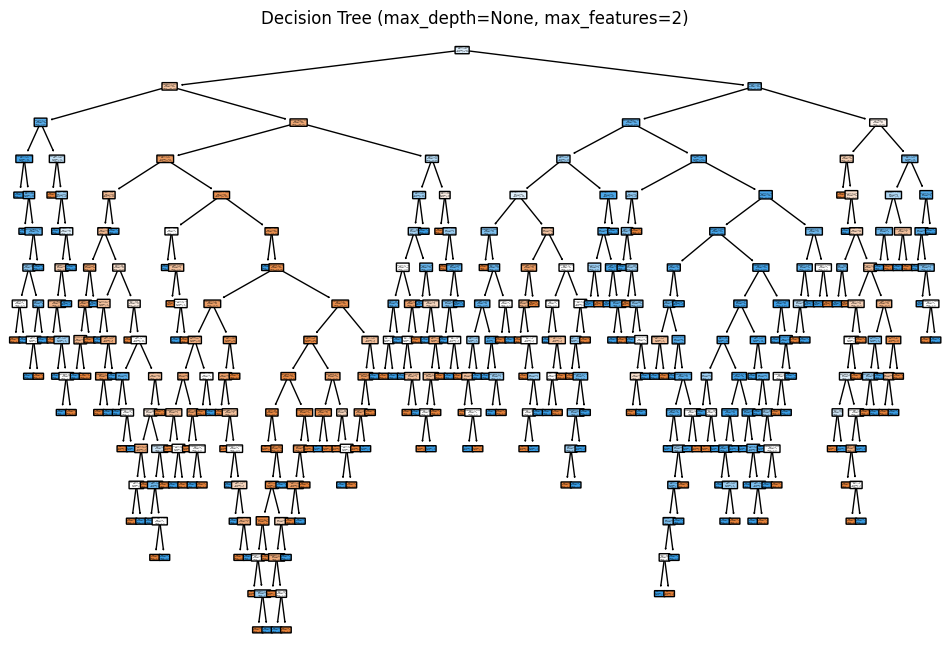

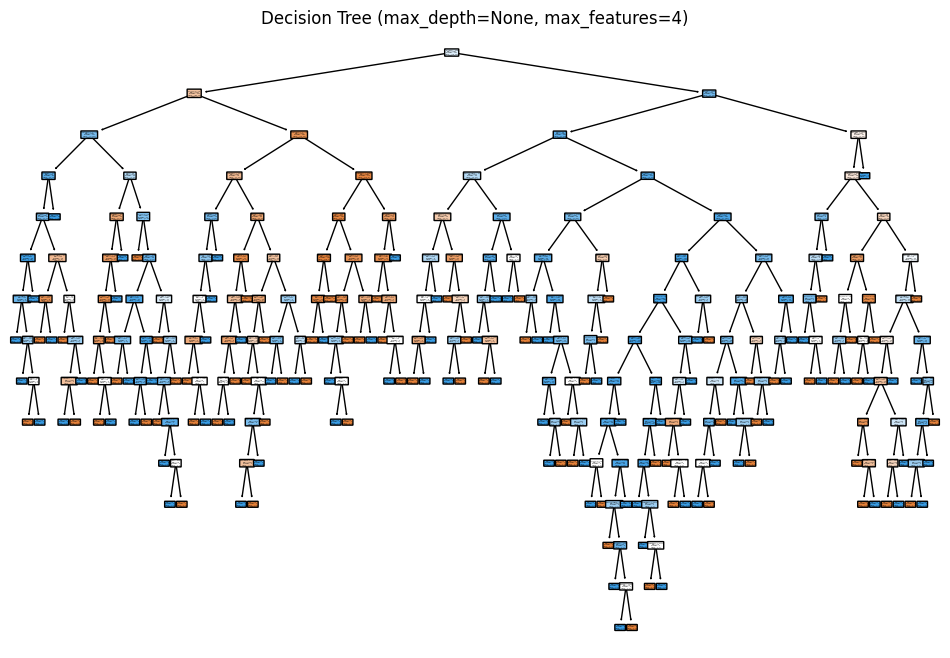

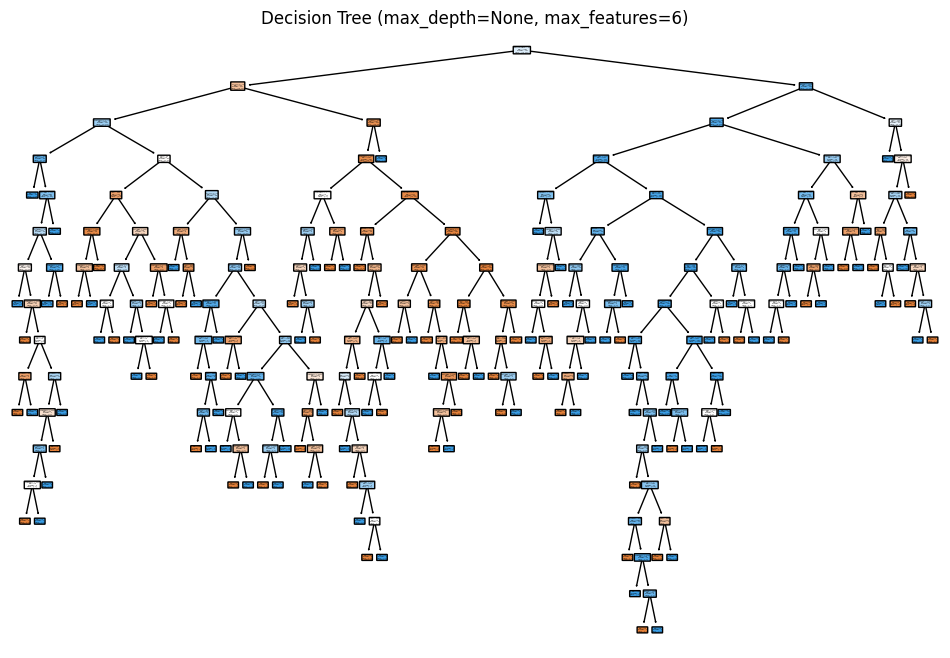

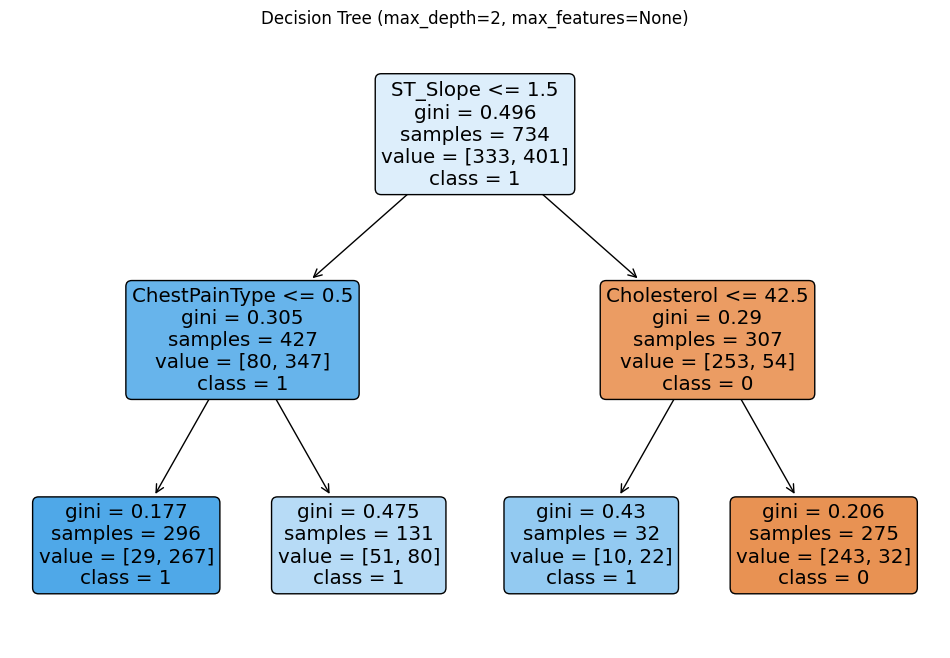

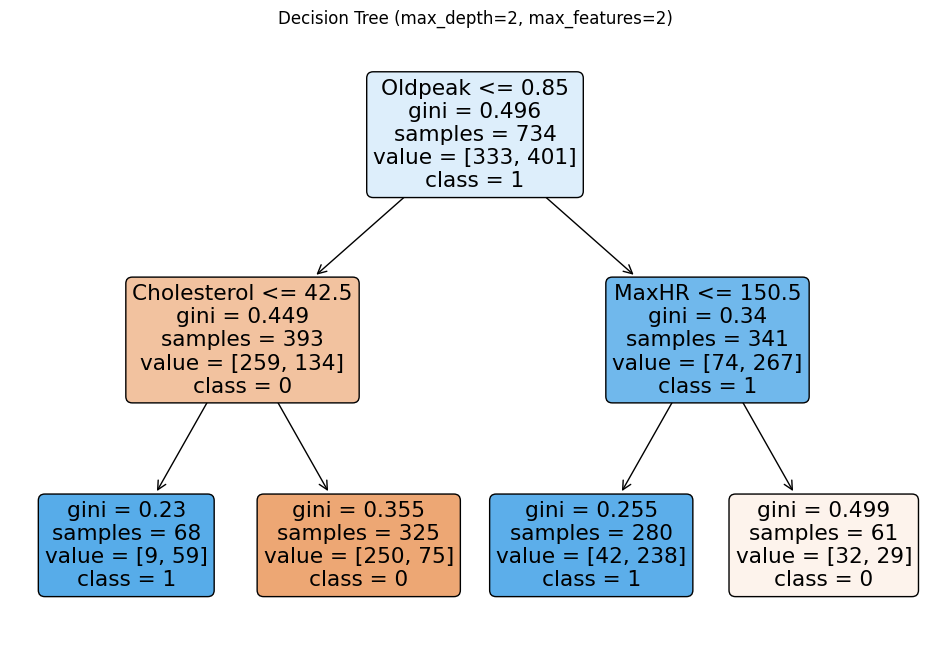

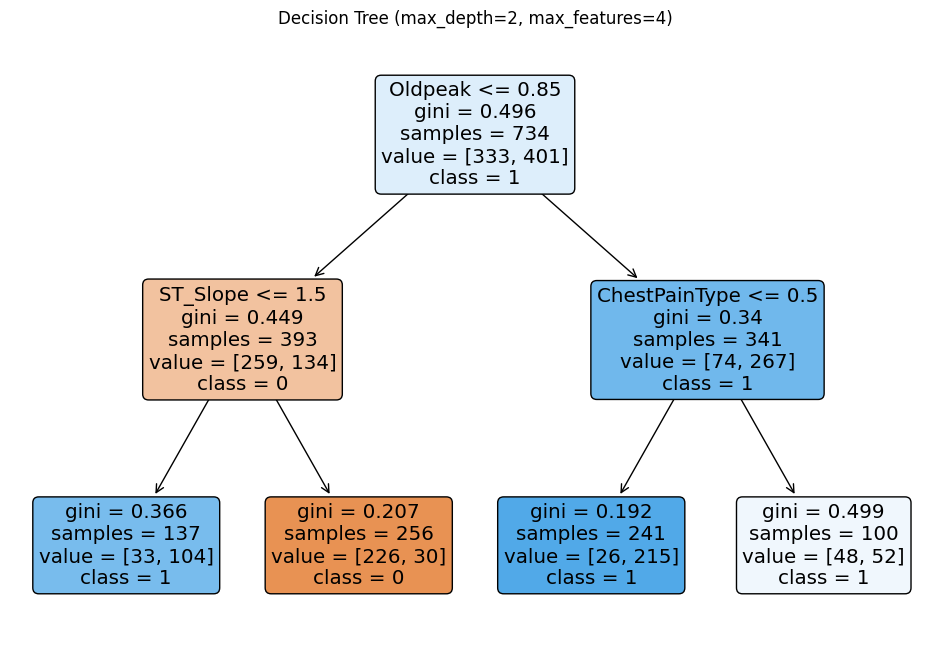

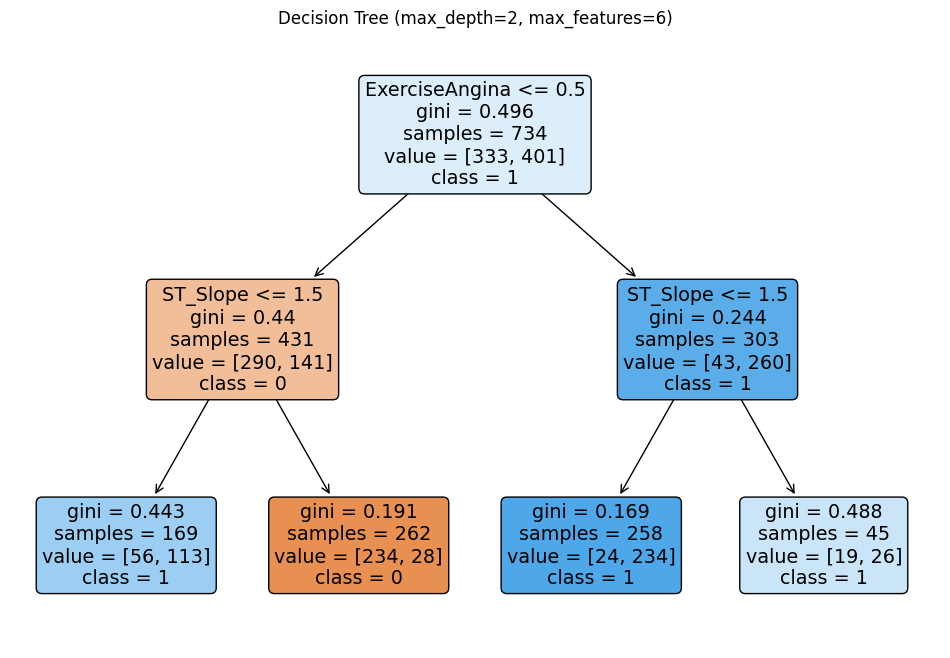

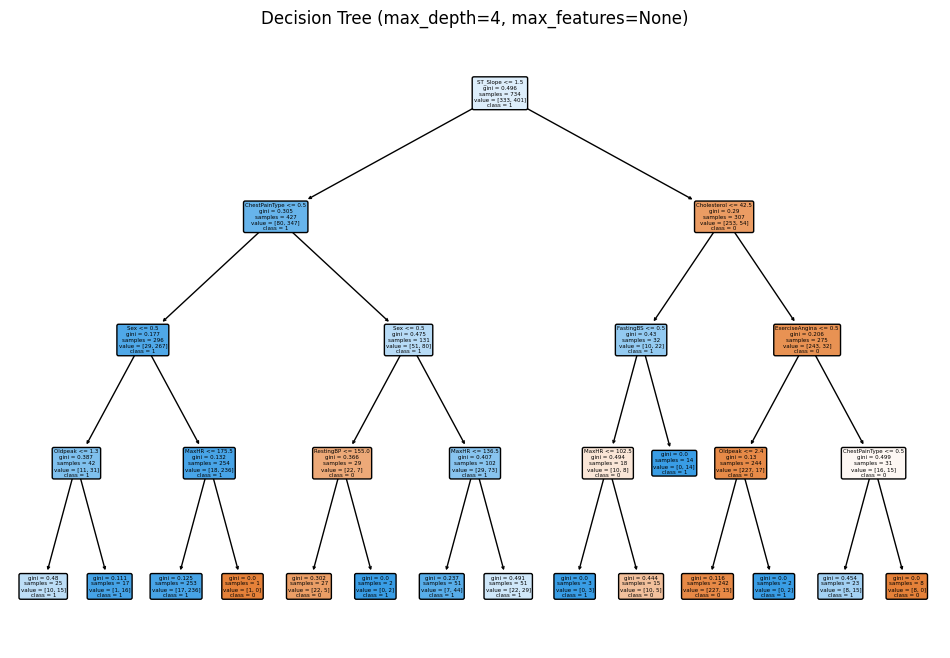

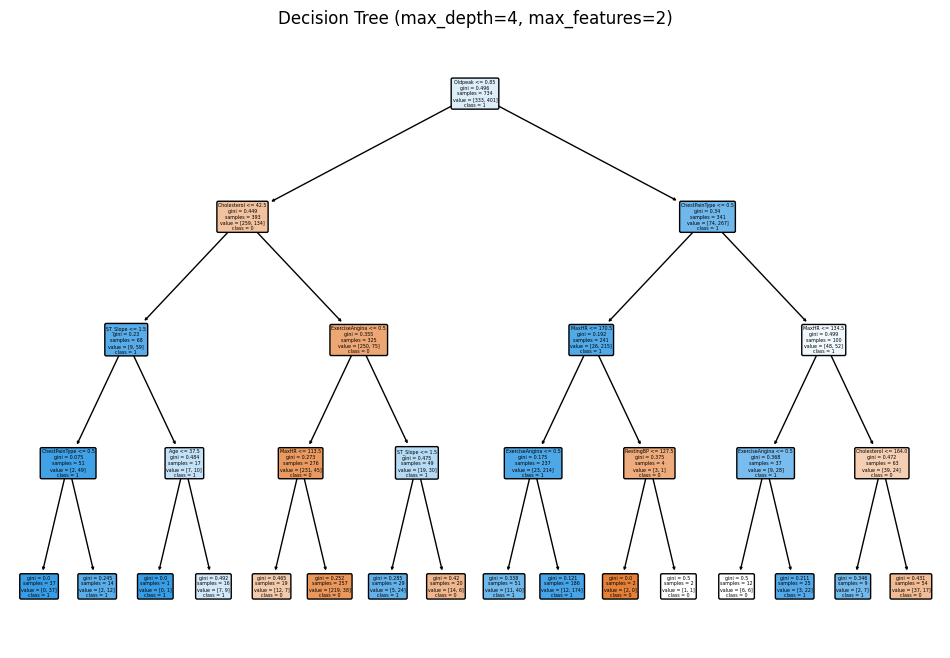

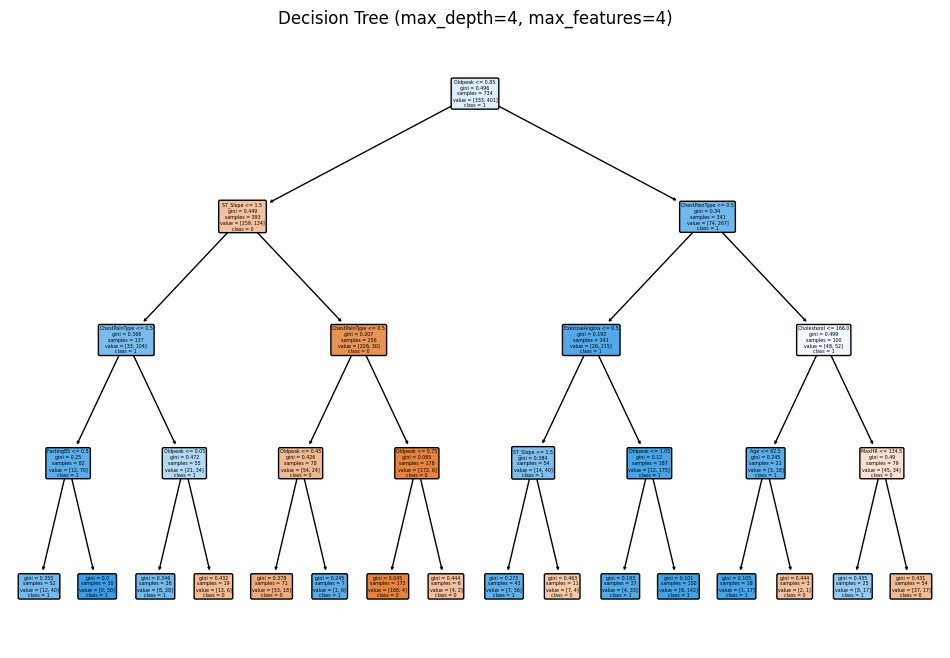

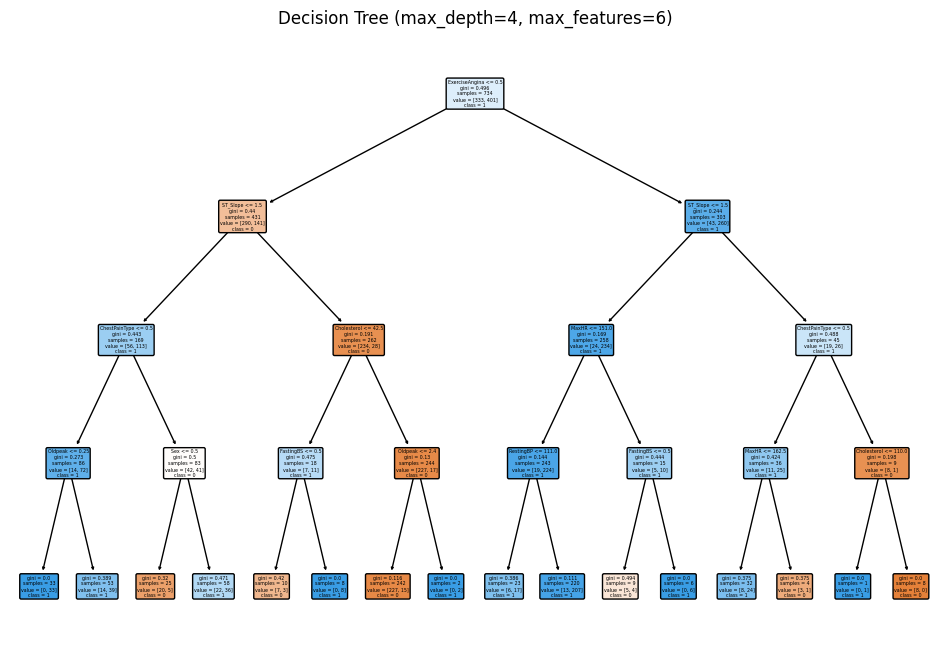

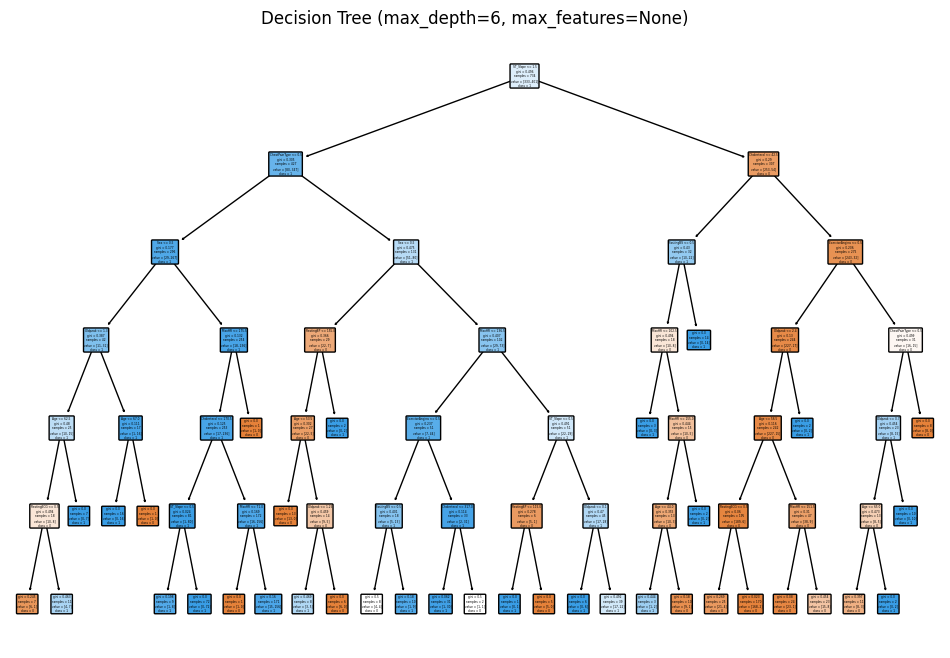

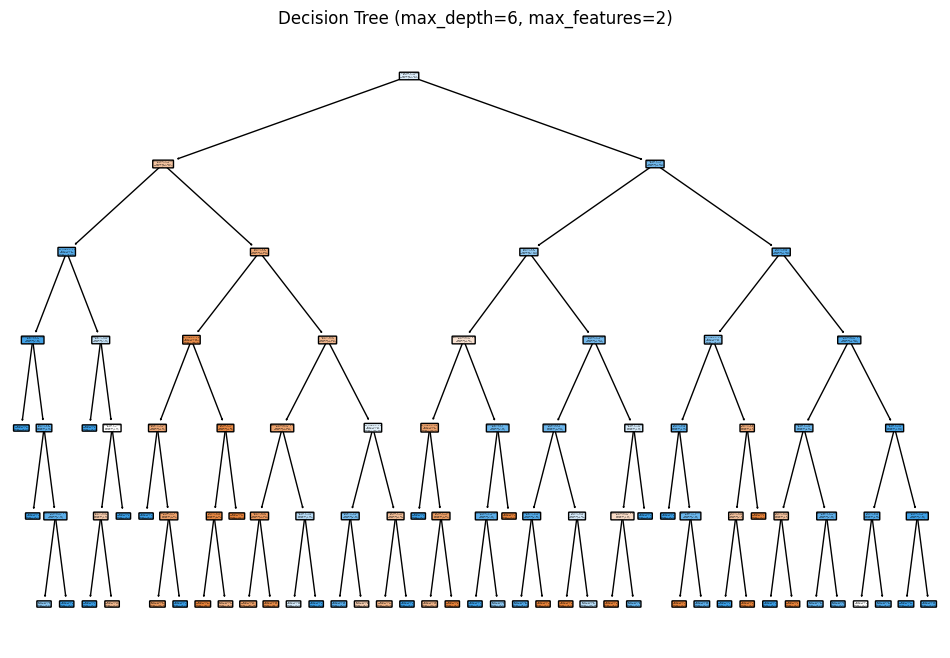

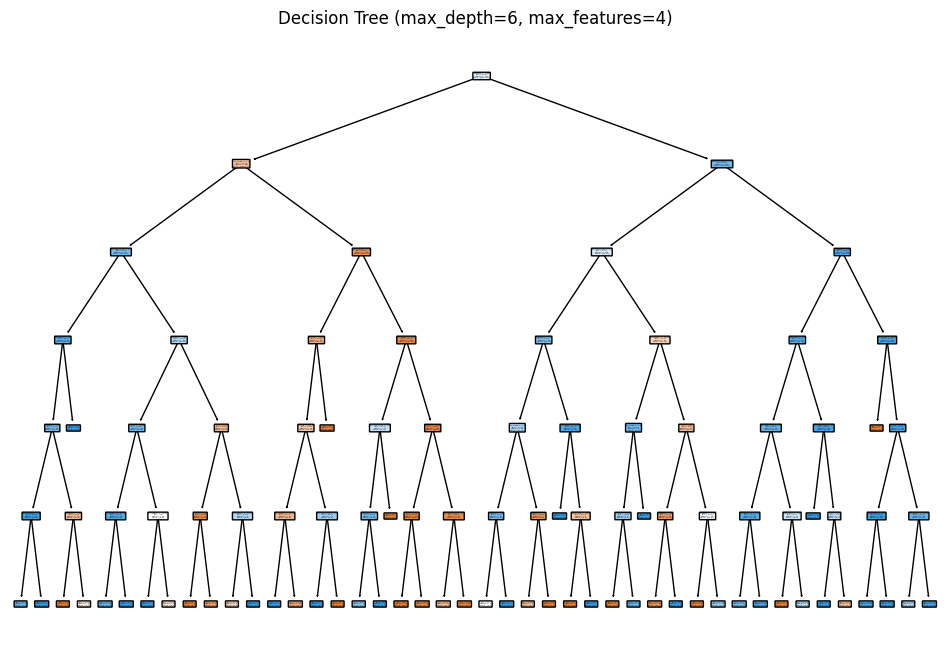

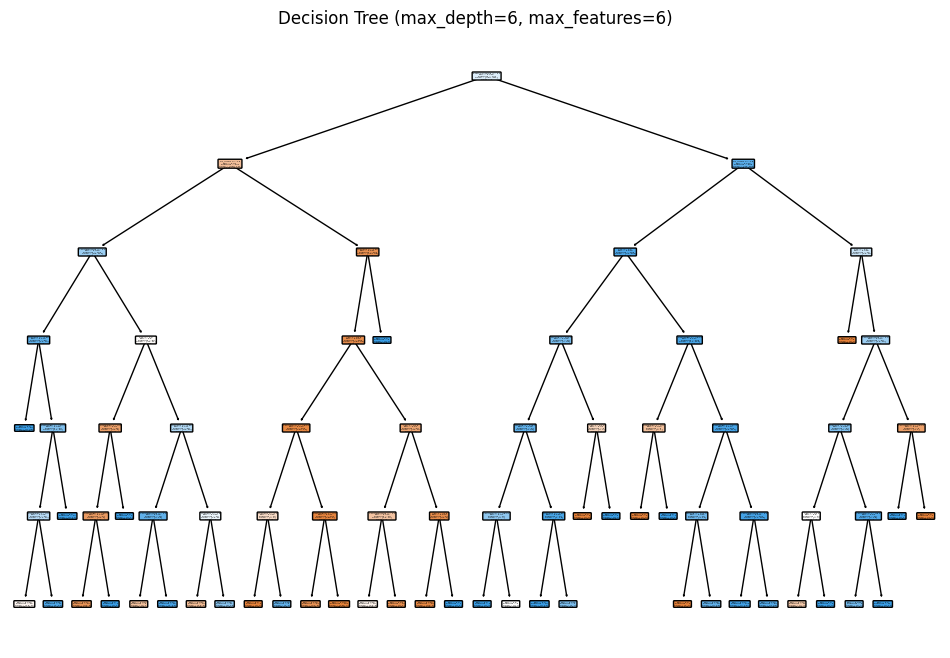

In [18]:
# Separate features (X) and target variable (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Classifier with different parameter settings and visualization
max_depths = [None, 2, 4, 6]
max_features = [None, 2, 4, 6]
for depth in max_depths:
  for feature in max_features:
    dtc = DecisionTreeClassifier(max_depth=depth, max_features=feature, random_state=42)
    dtc.fit(X_train, y_train)
    plt.figure(figsize=(12, 8))
    tree.plot_tree(dtc, filled=True, feature_names=X.columns, class_names=['0', '1'], rounded=True)
    plt.title(f"Decision Tree (max_depth={depth}, max_features={feature})")
    plt.show()


##Comment on how the depth and complexity change the tree.

When the maximum depth is higher, the tree becomes larger and has a lot more layers and information. This likely would make the performance of the tree better than with a smaller depth, as it breaks up the data more. Additionally, a similar thing can be said about the complexity. As the number of features increases, in general the tree changes shape and may appear differently distributed, especially when the maximum depth is higher. With less features, the shape of the tree does not change as much, but the values and order in the tree does change.

Sensitivity analysis is a method used to determine how changes in input to a model affects the output. This allows us to see how sensitive the model is to different features and parameters in a model, and it allows us to see how important certain features are on the performance of a model. In the paper cited below, they explain how they use sensitivity analysis for machine learning models in cardiac MRI. It explains that sensitivity analysis provides intuitive interpretations by transforming their input image in a controlled way and observing how that transformation impacts the performance of the model. The paper describes two methods: qualitative and quantitative. For qualitative, they perform segmentation on the original input and transformed versions of the input and present the results as overlays on the transformed images. For quantitative, the ground truth segmentation of the original image is used so that the performance is judged based on a similarity metric between the prediction and the ground truth. Additionally, with sensitivity analysis, you can perform weight perturbations on the data to test its impact on the output.

Reference: Ankenbrand, M.J., Shainberg, L., Hock, M. et al. Sensitivity analysis for interpretation of machine learning based segmentation models in cardiac MRI. BMC Med Imaging 21, 27 (2021). https://doi.org/10.1186/s12880-021-00551-1


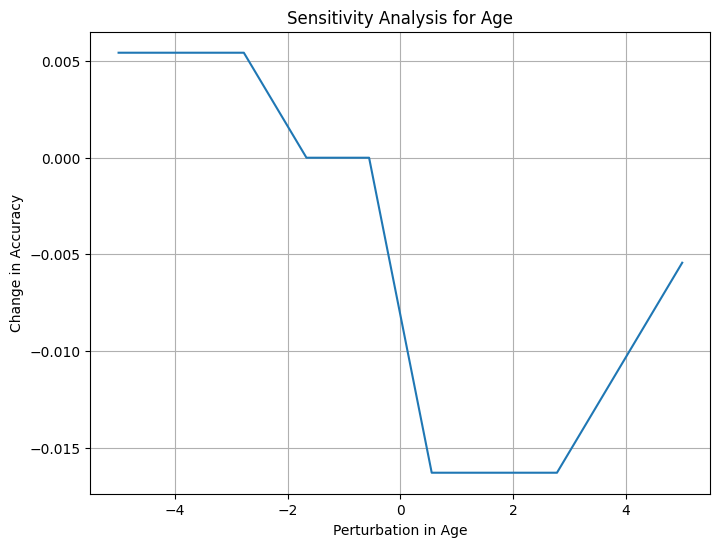

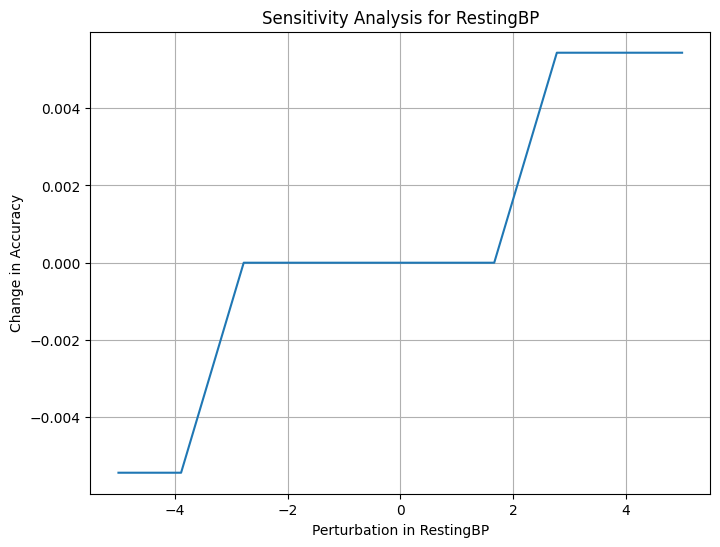

In [19]:
# Sensitivity Analysis
def sensitivity_analysis(model, X_test, y_test, feature_name, perturbation_range):
    original_predictions = model.predict(X_test)
    original_accuracy = accuracy_score(y_test, original_predictions)
    accuracy_changes = []
    perturbations = np.linspace(perturbation_range[0], perturbation_range[1], 10)
    for perturbation in perturbations:
        X_perturbed = X_test.copy()
        X_perturbed[feature_name] += perturbation
        perturbed_predictions = model.predict(X_perturbed)
        perturbed_accuracy = accuracy_score(y_test, perturbed_predictions)
        accuracy_changes.append(perturbed_accuracy - original_accuracy)
    return perturbations, accuracy_changes

# Perform sensitivity analysis on two attributes: 'Age' and 'RestingBP'
dtc = DecisionTreeClassifier(max_depth=None, max_features=None, random_state=42)
dtc.fit(X_train, y_train)

features_to_analyze = ['Age', 'RestingBP']  # Replace with your desired features
perturbation_range = (-5, 5)  # Adjust the range as needed

for feature in features_to_analyze:
    perturbations, accuracy_changes = sensitivity_analysis(dtc, X_test, y_test, feature, perturbation_range)
    plt.figure(figsize=(8, 6))
    plt.plot(perturbations, accuracy_changes)
    plt.xlabel(f"Perturbation in {feature}")
    plt.ylabel("Change in Accuracy")
    plt.title(f"Sensitivity Analysis for {feature}")
    plt.grid(True)
    plt.show()

The above code performs sensitivity analysis on the Decision Tree Classifier that is trained using the heart disease dataset. In the above sensitivity analysis, the goal was to understand how changes in two of the input features (age and resting blood pressure) affect the model's accuracy. This sensitivity analysis performs feature perturbation by making small changes in the feature values in the test data, and then it makes the predictions on the modified test data. The difference in accuracy of the original data and the perturbed data is calculated, with the change in accuracy as a function of the perturbation magnitude shown for each feature. From the graphs, we can determine how impactful these two features are for the model. For age, very small changes tend to show a steep change on the graph in accuracy, whereas with the small changes, resting blood pressure does not have a large effect on the accuracy. This suggests that for small changes in age, increasing age decreases the accuracy of the model, whereas for resting blood pressure, it does not have as much impact on the model's predictive performance.

In [20]:
# BaggingClassifier (Random Forest is a specific type of bagging)
bagging_model = BaggingClassifier(random_state=42)

# AdaBoostClassifier
boosting_model = AdaBoostClassifier(random_state=42)

# Define evaluation metrics
scoring = ['accuracy', 'precision', 'recall']

# Define folds for stratified k-fold cross-validation
folds = [5, 10, 15]

for n_splits in folds:
    print(f"\nStratified {n_splits}-fold Cross-Validation:")

    # Stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Evaluate BaggingClassifier
    bagging_results = cross_validate(bagging_model, X, y, cv=skf, scoring=scoring)
    print("BaggingClassifier:")
    for metric in scoring:
        print(f"  {metric.capitalize()}: {bagging_results[f'test_{metric}'].mean()}")

    # Evaluate AdaBoostClassifier
    boosting_results = cross_validate(boosting_model, X, y, cv=skf, scoring=scoring)
    print("AdaBoostClassifier:")
    for metric in scoring:
        print(f"  {metric.capitalize()}: {boosting_results[f'test_{metric}'].mean()}")

    #Compare performance
    print("Performance Comparison:")
    for metric in scoring:
      bagging_score = bagging_results[f'test_{metric}'].mean()
      boosting_score = boosting_results[f'test_{metric}'].mean()

      print(f"  {metric.capitalize()}: Bagging ({bagging_score:.4f}) vs Boosting ({boosting_score:.4f})")
      if bagging_score > boosting_score:
        print("    Bagging performs better")
      elif boosting_score > bagging_score:
        print("    Boosting performs better")
      else:
        print("    Both models perform equally")



Stratified 5-fold Cross-Validation:
BaggingClassifier:
  Accuracy: 0.8333214540270848
  Precision: 0.8520933259992665
  Recall: 0.84651523975927
AdaBoostClassifier:
  Accuracy: 0.8507483962936565
  Precision: 0.8634150408958323
  Recall: 0.8701805474665113
Performance Comparison:
  Accuracy: Bagging (0.8333) vs Boosting (0.8507)
    Boosting performs better
  Precision: Bagging (0.8521) vs Boosting (0.8634)
    Boosting performs better
  Recall: Bagging (0.8465) vs Boosting (0.8702)
    Boosting performs better

Stratified 10-fold Cross-Validation:
BaggingClassifier:
  Accuracy: 0.8322503583373149
  Precision: 0.854126737791076
  Recall: 0.8426666666666666
AdaBoostClassifier:
  Accuracy: 0.8539655996177735
  Precision: 0.8696337661879692
  Recall: 0.8681568627450981
Performance Comparison:
  Accuracy: Bagging (0.8323) vs Boosting (0.8540)
    Boosting performs better
  Precision: Bagging (0.8541) vs Boosting (0.8696)
    Boosting performs better
  Recall: Bagging (0.8427) vs Boosting 

##Comment on the behavior of each algorithm above under the metrics. Does the performance ranking change based on the metric used? Why?

The algorithms are all perform fairly well with statistics in the 0.8-0.9 range for all of the algorithms with each metric. From above, we can see that Boosting seems to perform better in each of the cases. The Bagging classifier creates subsets of training data and trains a base estimator (decision tree) on each subset, and predictions are made by aggregating the predictions of all the base estimators. This typically improves stability and reduces variance, which makes it less prone to overfitting. In the above problem, the performance of the Bagging model is generally consistent across all the metrics and fold numbers. The Boosting model (AdaBoost) focuses on training sequential training models rather than randomly selecting the smaller learners.

In this example, all of the metrics and rankings are relatively similar across all the folds. This could be due to the dataset not being super large, as there is therefore not enough data to see a large difference. However, in general, different metrics could result in different results for which method is better. Accuracy measures the correctness of the predictions, precision measures the proportion of correctly predicted positive instances out of all actual positives, and recall measures the proportion of correctly predicted positive instances out of all actual positive instances. A model could be high in one metric but low in others. In the problem defined above, all the metrics are relatively similar across the metrics and across the number of folds, which is likely due to the smaller size of the dataset.

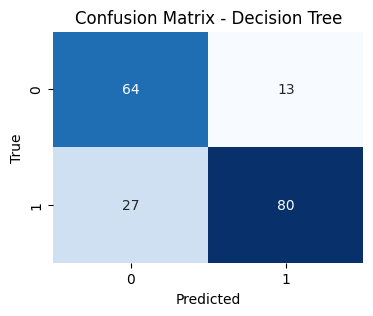

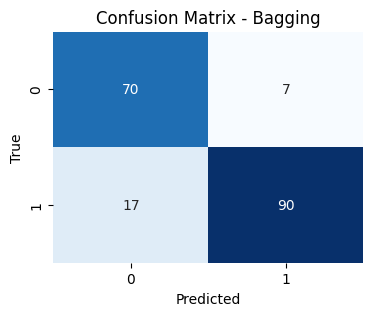

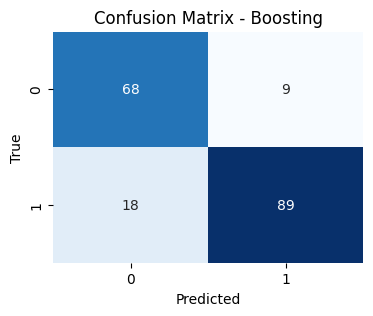

Paired t-test (Decision Tree vs. Bagging): t-statistic = -0.755, p-value = 0.451
Paired t-test (Decision Tree vs. Boosting): t-statistic = -0.821, p-value = 0.413
Paired t-test (Bagging vs. Boosting): t-statistic = -0.229, p-value = 0.819


In [23]:
# Fit the bagging model to the entire training data
bagging_model.fit(X_train, y_train) # Added line to fit the model

# Fit the boosting model to the entire training data
boosting_model.fit(X_train, y_train)

# Predictions
y_true = y_test
y_pred_dt = dtc.predict(X_test)
y_pred_bagging = bagging_model.predict(X_test)
y_pred_boosting = boosting_model.predict(X_test)

# 1. Confusion Matrix (Decision Tree as an example)
cm = confusion_matrix(y_true, y_pred_dt)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

cm = confusion_matrix(y_true, y_pred_bagging)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Bagging')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

cm = confusion_matrix(y_true, y_pred_boosting)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Boosting')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Paired t-test
# Comparing Decision Tree and Bagging
t_statistic, p_value = ttest_rel(y_pred_dt, y_pred_bagging)
print(f"Paired t-test (Decision Tree vs. Bagging): t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Comparing Decision Tree and Boosting
t_statistic, p_value = ttest_rel(y_pred_dt, y_pred_boosting)
print(f"Paired t-test (Decision Tree vs. Boosting): t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Comparing Bagging and Boosting
t_statistic, p_value = ttest_rel(y_pred_bagging, y_pred_boosting)
print(f"Paired t-test (Bagging vs. Boosting): t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")



##Discuss tradeoff between bias and variance for each model

Decision Trees have high variance, indicating they are prone to overfitting, especially with a larger depth for the trees. Changes in the training data can significantly alter the structure of the tree. On the other hand, they have low bias, so they are able to identify complex relationships within the data.

Bagging, in this case Random Forest is the model used, has lower variance but slightly higher bias. From the lower variance, we can see that aggregating predictions from multiple trees reduces overfitting. However, there is a higher bias as the model is trained on random subsets of data, so it is possible that some data could be reused, creating bias.

Boosting, in this case AdaBoost is the model used, has lower bias as it sequentially trains the model on smaller datasets. However, it could have higher variance as it could be sensitive to outliers. It would have a higher variance than the Bagging method but a lower variance than a Decision Tree.

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}
Accuracy: 0.8804347826086957
F1-score: 0.8952380952380954
Precision: 0.912621359223301
Recall: 0.8785046728971962

Sensitivity Analysis (based on cross-validation results):

Parameter: learning_rate
  Value: 0.001, Mean Accuracy: 0.6157, Std Dev: 0.0927
  Value: 0.01, Mean Accuracy: 0.8514, Std Dev: 0.0252
  Value: 0.1, Mean Accuracy: 0.8679, Std Dev: 0.0194

Parameter: max_depth
  Value: 3, Mean Accuracy: 0.6157, Std Dev: 0.0927
  Value: 5, Mean Accuracy: 0.7275, Std Dev: 0.0237
  Value: 7, Mean Accuracy: 0.7248, Std Dev: 0.0250

Parameter: subsample
  Value: 0.8, Mean Accuracy: 0.6157, Std Dev: 0.0927
  Value: 0.9, Mean Accuracy: 0.6144, Std Dev: 0.0876
  Value: 1.0, Mean Accuracy: 0.6416, Std Dev: 0.1177


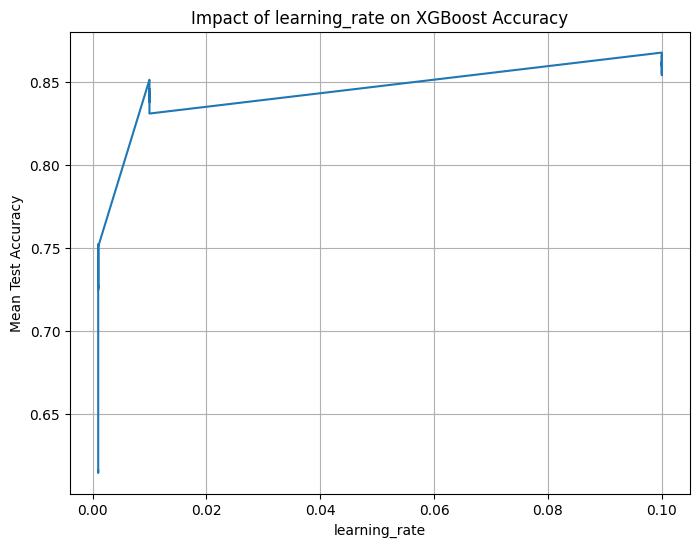

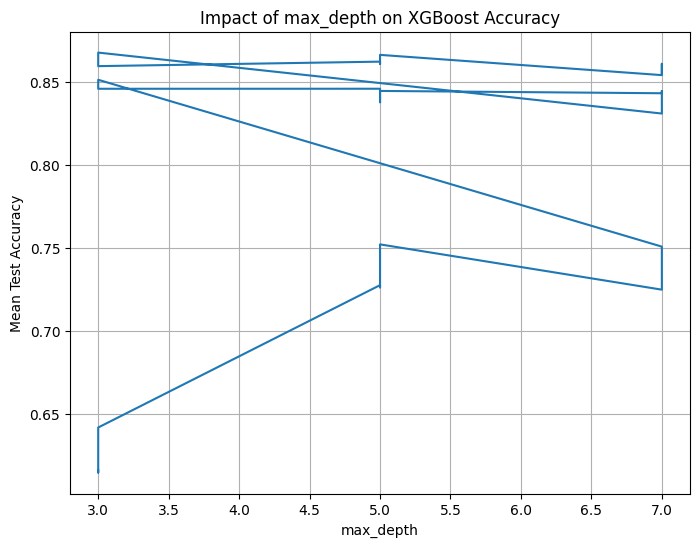

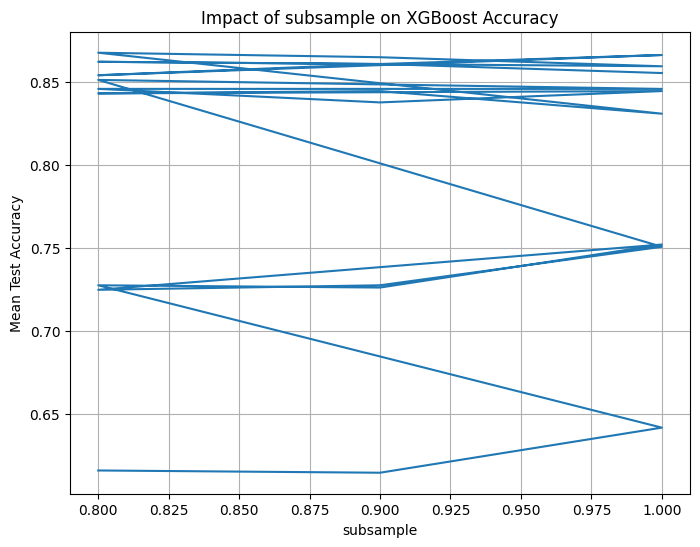

In [35]:
# Make XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Analyze sensitivity
cv_results = grid_search.cv_results_

print("\nSensitivity Analysis (based on cross-validation results):")
for param_name in param_grid:
  print(f"\nParameter: {param_name}")
  for i in range(len(param_grid[param_name])):
    param_value = param_grid[param_name][i]
    mean_score = cv_results[f'mean_test_score'][cv_results[f'param_{param_name}'] == param_value][0]
    std_score = cv_results[f'std_test_score'][cv_results[f'param_{param_name}'] == param_value][0]
    print(f"  Value: {param_value}, Mean Accuracy: {mean_score:.4f}, Std Dev: {std_score:.4f}")


for param_name in param_grid:
    plt.figure(figsize=(8, 6))
    param_values = [params[param_name] for params in grid_search.cv_results_['params']]
    plt.plot(param_values, grid_search.cv_results_['mean_test_score'])
    plt.xlabel(param_name)
    plt.ylabel('Mean Test Accuracy')
    plt.title(f'Impact of {param_name} on XGBoost Accuracy')
    plt.grid(True)
    plt.show()

From the statistics and graphs above, it can be seen that the mean test accuracy increases on average with increased learning rate, indicating that the model is sensitive to changes in the learning rate. However, for max_depth and subsample, the changes in mean test accuracy are less noticalbe, indicating that the model is less sensitive to changes in those parameters. However, the mean accuracy did not change very much for any of the hyperparamters, which could be due to the size of the dataset being smaller. A larger difference might be observed with a larger dataset to train the model on.